# Part 1 : Sampling and filtering

In this part of the lab work, we are going to look at the frequency content of images, and certain filtering operations which which we can carry out.

__Note__ : When viewing the result of filtered images, we will avoid using ```plt.imshow()```. Indeed, if you use imshow to display an image, it will change the resolution of this image. Since we are going to be looking at aliasing effects (which is induced precisely by changing resolution), it is better to write the output to an image file and view it in a separate program.

However, you can (and will) use ```plt.imshow()``` for displaying the image's spectra and for displaying filters.

First, let us load the necessary packages

### Your task

In the lab work, you must fill in the code in the places marked FILL IN CODE, or answer the written questions directly on the notebook.

First, let us load the necessary packages

In [4]:
from matplotlib import pyplot as plt
import numpy as np 
import imageio
from skimage import color


is_colab = False

The last package will help us to carry out the convolution operation. Let's define two functions to read and write and image :

In [5]:
def read_image(file_name):
    img_color = imageio.imread(file_name)
    img_gray = color.rgb2gray(img_color)
    return img_gray,img_color
    
def write_image(img_in,file_name_out):
    imageio.imwrite(file_name_out, np.uint8(255.0*img_in))

In [6]:
file_dir = 'images/'
file_name = 'boston'
file_ext = '.png'

if (is_colab == True):
  !wget "https://perso.telecom-paristech.fr/anewson/doc/images/boston.png"
  img_gray,_ = read_image(file_name+file_ext)
else:
  img_gray,_ = read_image(file_dir+file_name+file_ext)
img_gray.shape

(600, 600)

## Frequency content

Firstly, we are going to inspect the frequency content of the image. Write a function to display the magnitude of the spectrum of the image. For this, you can use the following functions

- ``np.fft.fft2``
- ``np.fft.fftshift``

The first calculates the 2D Fast Fourier Transform of the image. The second centres the spectrum, such that the 0 frequency is centred in the image. Otherwise the 0 point is set at the top left, which is not very conveniant for visualisation.

A final note. It is often the case that the 0 frequency is of much larger amplitude than the other frequencies. Therefore, we often visualise log(1+spectrum_magnitude) rather than spectrum_magnitude itself.

Write this function ``display_spectrum`` now.

In [7]:
def display_spectrum(img): 
    spectrum = np.fft.fft2(img)
    spectrum = np.abs(spectrum)
    spectrum_centered = np.fft.fftshift(spectrum)
    spectrum_normalized = np.log(1+spectrum_centered)
    return plt.imshow(spectrum_normalized)

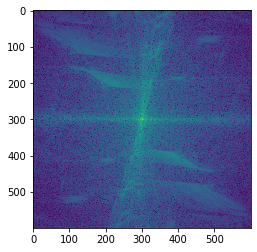

In [8]:
display_spectrum(img_gray)

__Question__ : What do you observe in the frequency domain ? What is your interpretation of this image ?

__Answer__ : On observe que nous avons des fréquences très élevées qui apparaissent dans le spectre. Lors du rééchantillonnage, il est très clair que nous allons devoir filtrer l'image, sinon nous allons être confrontés à du aliasing. 

## Subsampling and aliasing

We are now going to carry out a ''direct'' subsampling (also known as a ''nearest neighbours'' subsampling) of a factor $\delta$, that is to say we simply take one out of every $\delta$ pixels. Fill in the following function to do this :

In [9]:
def nn_subsampling(img_in,delta):
    shape = img_in.shape
    new_image = np.zeros((int(shape[0]/delta),int(shape[1]/delta)))
    for i in range(int(shape[0]/delta)):
        for j in range(int(shape[1]/delta)):
            new_image[i,j] = img_in[delta*i,j*delta]
    return new_image

We write the subsampled image, with subsampling step $\delta = 2$

In [10]:
delta = 2
image_small = nn_subsampling(img_gray,delta)
write_image(image_small, file_name+'_subsampled.png')

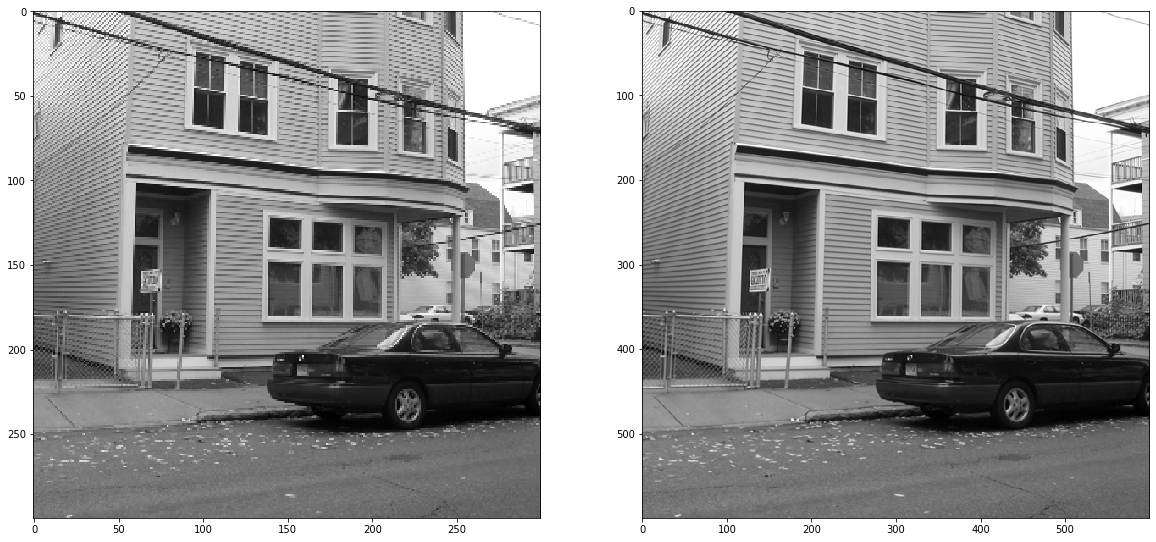

In [11]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(image_small,cmap='gray')
plt.subplot(1,2,2)
plt.imshow(img_gray,cmap='gray')

__Question__ What do you notice about the image ? Where is the aliasing taking place ? Why is it taking place in these specific regions ?

__Answer__ : 
On remarque l'apparition d'un phénomène d'aliasing dans l'image réduite. Ce phénomène a principalement lieu au niveau des bords et des contours des objets contenus dans l'image, puisque ces lieux correspondent aux hautes fréquences contenues dans l'image.

We have seen two different methods of filtering an image before subsampling to remove high frequencies :

- Ideal low-pass filter
- Gaussian filter

We recall that the convolution operation, which defines a filter, can be carried out either in the spatial (image) domain or the frequency domain.

First, write a function which filters an input image via the frequency domain, with the input filter ``f_hat`` defined in the frequency domain. The output ``img_out`` should be in the spatial domain. You can use the ``np.fft.ifft2`` function to carry out the inverse Fourier transform. Make sure to take the __real__ part of the output image (``np.real``).

In [12]:
def filter_image(img,f_hat):
    spectrum = np.fft.fft2(img)
    convolution = np.multiply(spectrum,f_hat)
    img_out = np.fft.ifft2(convolution)
    return(np.real(img_out))

### Ideal low-pass filter

Now, we are going to create a function ``ideal_low_pass_filter`` which returns an ideal low-pass filter $\hat{h}$ in the frequency domain. We recall that in 2D this is a disk centred on the 0-frequency (with the radius $\nu_0$ which is the cut-off freqeuncy).

### Creating the disk (low-pass filter) in the frequency domain 

By definition the 0 frequency is at the top left point of the image. Therefore, you have two options to create the filter :

- you can create the low-pass filter in the 'normal' frequency-domain representation, with the 0 frequency at the (0,0) position of the frequency image)
- you can create the low-pass filter in the 'centred' position and then ifftshift the frequency image. In the centred representation of the frequency, for an image of even size $n=2a$, the 0 frequency position is located at position $a$ (where 0 is the first position - the '0 indexing' of python).

To go between the two representations, you have the following functions :

- np.fft.fftshift : top-left centre -> middle centre
- np.fft.ifftshift : middle centre -> top-left centre

To create the disk centred at the position $a$, you have several options :

- use a loop (simplest, but potentially slow)
- use the np.meshgrid function, (https://docs.scipy.org/doc/numpy/reference/generated/numpy.meshgrid.html) which creates a grid of positions (in 1D, 2D, etc - here we are interested in 2D)
- use the 'distance transform' ``scipy.ndimage.morphology.distance_transform_edt``. This function calculates the distance to the nearest pixel which has a value of 0 in a binary image (this is a mathematical morphology function)
- or anything else that you can think of :)

In [13]:
from scipy.ndimage.morphology import distance_transform_edt

def ideal_low_pass_filter(img_shape,nu_0):
    
    n = img_shape[0]
    a = n//2
    f_hat = np.ones(img_shape)
    
    f_hat[0,0] = 0
    f_hat[n-1,n-1] = 0
    f_hat[0, n-1] = 0
    f_hat[n-1, 0] = 0
    
    f_hat = distance_transform_edt(f_hat)
    f_hat /= f_hat.max()

    f_hat[f_hat <= nu_0] = 1
    f_hat[(f_hat < 1)] = 0
    
    f_hat = np.fft.fftshift(f_hat)
    
    f_hat[0,0] = 0
    f_hat[n-1,n-1] = 0
    f_hat[0, n-1] = 0
    f_hat[n-1, 0] = 0
    
    f_hat = np.fft.ifftshift(f_hat)
    
    return f_hat

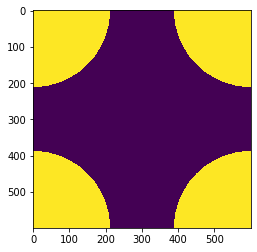

In [14]:
plt.imshow(ideal_low_pass_filter([600,600],0.5))

__Question__ Given that in an image with sampling rate 1 (the pixel size) the frequencies in the original image of size $n \times n$ go from $-\frac{1}{2}$ to $\frac{1}{2}$.  For a subsampling of $\delta=2$, where should the cutoff frequency $\nu_0$ be set for correct subsampling ?

__Answer__ : On a d'après le cours: $\sigma = \frac{1}{2\nu_0}$, donc $\nu_0 = \frac{1}{2\sigma}=\frac{1}{4}$

Create f_hat, the ideal low-pass filter in the frequency domain, and display it.

(600, 600)


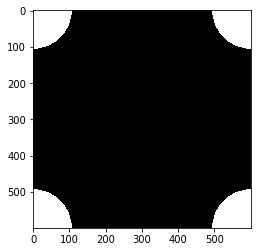

In [15]:
img_shape = img_gray.shape
print(img_shape)
nu_0 = 1/4   #FILL IN THIS VALUE
f_hat = ideal_low_pass_filter(img_shape,nu_0)
plt.imshow(f_hat,cmap='gray')
plt.show()

Carry out the filtering, and subsample the image again, and imwrite the result.

You should observe that the range of the image is not respected. Make sure to rescale the output image to the range $0, \dots, 1$ before writing it.

__Bonus question__ Why do you think this happens ?

__Answer__ : Un filtrage est la convolution d'une image et d'un filtre dans le domaine spatial. Dans le domaine fréquenciel, le filtre passe-bas idéal est une fonction $\operatorname{sinc}$. Comme la fonction $\operatorname{sinc}$ prend des valeurs en dehors de $[0,1]$, il est normal que la plage de l'image de sortie ne soit pas respectée.

In [16]:
img_filtered = filter_image(img_gray,f_hat)

img_filtered = img_filtered - img_filtered.min()# CODE HERE
img_filtered = img_filtered / img_filtered.max() 

img_filtered = nn_subsampling(img_filtered,delta)

write_image(img_filtered,file_name+'_filtered_ideal_low_pass.png')

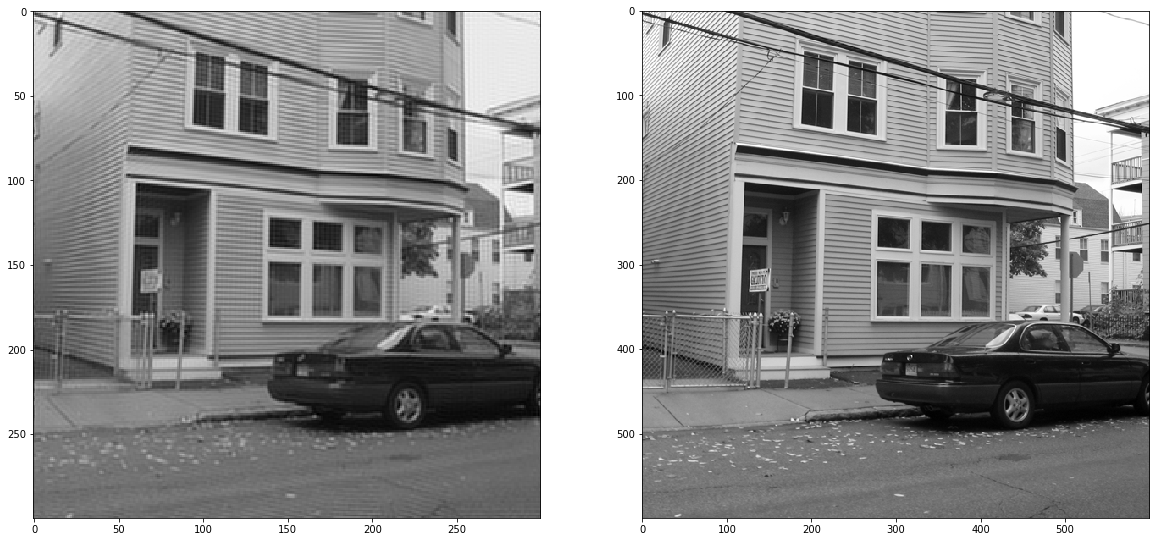

In [17]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(img_filtered,cmap='gray')
plt.subplot(1,2,2)
plt.imshow(img_gray,cmap='gray')

__Question__ Is the aliasing reduced ? What effect do you notice in the output ? What is this called ?

__Answer__ L'aliasing est effectivement réduit.
On remarque l'apparition de "petits carreaux" sur l'image. Ceci est appelé "ringing artefacts".


### Gaussian filter

Now, we are going to carry out the filtering with a Gaussian filter. Create a function ``gaussian_filter`` which returns a 2D Gaussian filter, defined as :

$g_\sigma(x,y) = \frac{1}{2 \pi \sigma^2} \exp{ \left( - \frac{x^2+y^x}{2\sigma^2} \right)}$

To create a grid of pixel positions, you can use the ``np.meshgrid`` function.

You must again make sure to carry out an ``ifftshift`` to make sure the filter is in the correct format. Be careful to put the middle of the Gaussian at the centre position ($a$).

In [18]:
def gaussian_filter(img_shape,sigma):
    # FILL IN, CREATE g
    denom = 2*np.pi*(sigma**2)
    n = img_shape[0]
    ind = np.zeros(n)
    a = n // 2
    maxi = 20 * sigma**2
    ind[0:a] = np.linspace(-maxi, 0, a)
    ind[a: ] = np.linspace(0, maxi, a+1)[1:]
    i,j = np.meshgrid(ind, ind, indexing = 'ij')
    g = np.exp(-(i**2 + j**2) / (2* sigma**2)) / denom
    g = np.fft.ifftshift(g)  
    g_hat = np.abs(np.fft.fft2(g))
    return g

Now, create a Gaussian filter in the frequency domain to attenuate the frequencies higher than the previous cutoff frequency you used above, $\nu_0$. To do this, we recall that 95.45 percent of the energy of a Gaussian function is contained within $\pm 2\sigma$. Fix $\sigma$ accordingly. Display the filter.

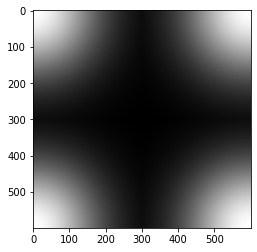

In [19]:
sigma = 0.12
g_hat = gaussian_filter(img_gray.shape,sigma)
plt.imshow(g_hat,cmap='gray')

Now, carry out the filtering with the Gaussian filter in the frequency domain. Remember to renormalise the output image.

In [20]:
img_filtered = filter_image(img_gray,g_hat)
img_filtered = img_filtered - img_filtered.min()# CODE HERE
img_filtered = img_filtered / img_filtered.max() 
img_filtered = nn_subsampling(img_filtered,delta)

write_image(img_filtered,file_name+'_filtered_gaussian.png')

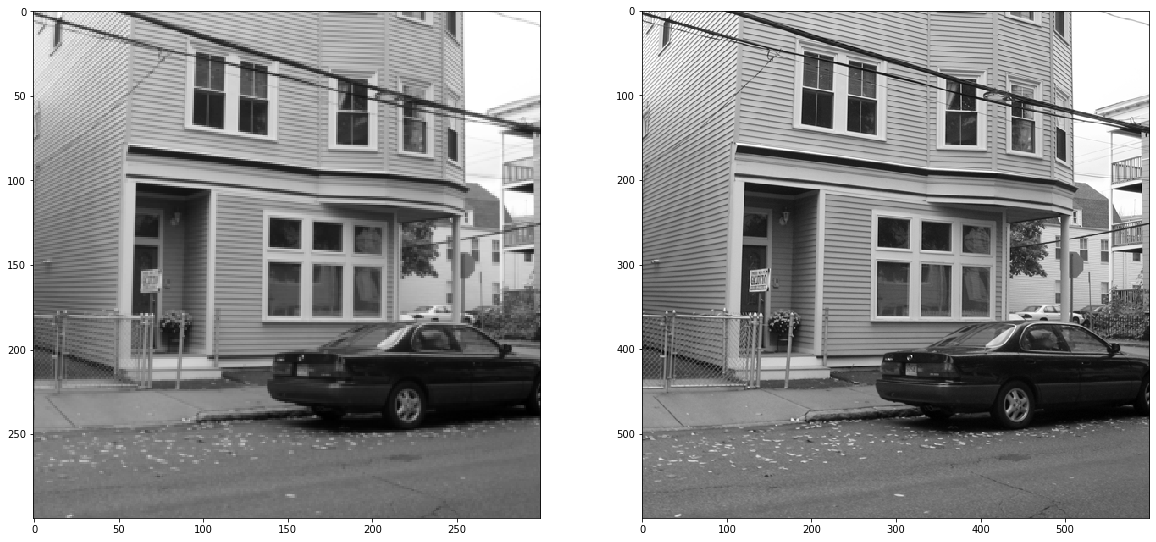

In [21]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(img_filtered,cmap='gray')
plt.subplot(1,2,2)
plt.imshow(img_gray,cmap='gray')

__Question__ Do you still observe the problem observed in the case of the ideal low-pass filter ? Why ?

__Answer__ Nous n'observons plus le phénomène précédent car dans le cas d'un filtre gaussien, en passant dans le domaine fréquentiel, on aboutit à une fonction gaussienne et non plus à un sinus cardinal (c'est le sinus cardinal qui causait l'apparition de ringing artifacts).

__Bonus Question__ We have had to rescale the output image again. This time, why was this the case ? Hint : think about a Gaussian filter in the spatial domain with a very large $\sigma$.

__Answer__

## Standard filters

In this section, we are going to look at some common filters, and see their effects on images. From this point on in the TP, we are going to be working in the spatial domain, and are no longer concentrated on aliasing. Therefore, we can use the plt.imshow function (you may notice some aliasing, but we ignore it here). We define a display function now.

In [22]:
def display_image(img_in):
    plt.imshow(img_in,cmap ='gray')
    plt.show()
    return 

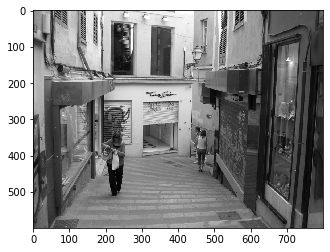

In [23]:
file_dir = 'images/'
file_name = 'palma'
file_ext = '.png'

if (is_colab == True):
  !wget "https://perso.telecom-paristech.fr/anewson/doc/images/palma.png"
  img_gray,_ = read_image(file_name+file_ext)
else:
  img_gray,_ = read_image(file_dir+file_name+file_ext)
img_gray.shape

display_image(img_gray)

Now, write a function ``filter_image_spatial`` which carries out the 2D convolution between two images in the spatial domain. For this, you can use the ``convolve2d`` from the scipy.signal package. In this convolution, you should use the following parameters :

- mode='same'. This means that the output size of the image will be the same as the input
- boundary='symm'. For values outside the image domain, we take the symmetrical values of the image

Strictly speaking, if we take the Fourier transform of an image, we are using periodic boudary conditions. However, at this point we no longer need the frequency representation of the image, so we can define the conditions as we wish.

In [24]:
from scipy import signal

def filter_image_spatial(img,f):
    img_out = signal.convolve2d(img,f, mode='same', boundary='symm')
    return(img_out)

Now, define the filters grad_y and grad_x which give the derivatives of the image in the $y$ and $x$ directions, respectively (see lesson slides). Note : you must define these filters in the spatial domain, and make sure that they are matrices (otherwise the dimensions will not match with those of the image);

In [25]:
grad_x = np.array([[-1,1],[0,0]]) # FILL IN CODE
grad_y = np.array([[-1,0],[1,0]]) # FILL IN CODE

In [26]:
grad_x

array([[-1,  1],
       [ 0,  0]])

In [27]:
grad_y

array([[-1,  0],
       [ 1,  0]])

Filter the input image and display the results of these two filterings

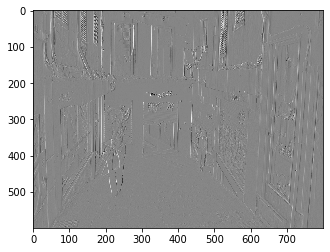

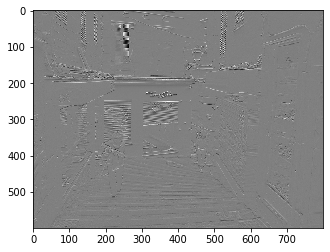

In [28]:
img_grad_x = filter_image_spatial(img_gray,grad_x)
img_grad_y = filter_image_spatial(img_gray,grad_y)

display_image(img_grad_x)
plt.figure()
display_image(img_grad_y)

### Image sketch (edge detection)

Suppose we wish to create a sketch of our image, with just the outlines of object. Propose a (simple) method to create a binary image where the edges are detected (using the previous filters and a threshold parameter $\tau$). Implement this in a function called ``sketch_image``, and apply it to the input image. Display it (you can write it as well to view it better).

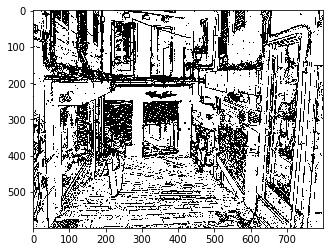

[0. 1.]


In [29]:
def sketch_image(img_in,tau):
    # FILL IN CODE
    img_grad_x = filter_image_spatial(img_in,grad_x)
    img_grad_y = filter_image_spatial(img_in,grad_y)
    img_out = img_in.copy()
    
    norm = np.sqrt(img_grad_x**2 + img_grad_y**2)
    
    img_out[norm < tau ] = 1
    img_out[norm >= tau ] = 0

    return img_out


tau = 0.03
img_sketch = sketch_image(img_gray,tau)
display_image(img_sketch)
write_image(img_sketch, file_name+'_sketch.png')
print(np.unique(img_sketch))

## Further refinement (no code to fill in or questions here)

Depending on the threshold parameter used in your algorithm, the sketch may have a certain thickness. Ideally, we would like to have a sketch of one-pixel thickness. This is something we would like to avoid in the sketch. In the lesson we saw a morphological operator, the "skeletonisation" operator, which you can find the necessary function in the following package :

- skimage.morphology

Below, we show what this does to the sketch image

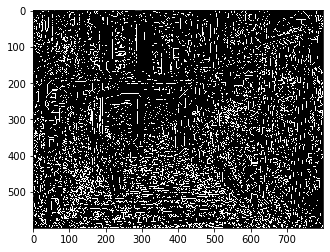

In [30]:

from skimage.morphology import skeletonize

img_sketch_skeleton = skeletonize(img_sketch)
display_image(img_sketch_skeleton)
write_image(img_sketch_skeleton, file_name+'_sketch_skeleteon.png')
